In [1]:
import os
import warnings
import contextlib

warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from argparse import Namespace

import jax
from jax import jit
import jax.numpy as jnp
import numpy as np
import os
import copy
import matplotlib.cm as cm


from jax_md import space
from jax_md.partition import Sparse
from cases import select_case
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.pyplot as plt


from jax_sph.solver.sph_tvf import SPHTVF
from jax_sph import partition
from jax_sph.integrator import si_euler
from jax_sph.io_state import read_h5, write_h5

from jax_sph.simulate import simulate

2024-02-10 22:00:46.093050: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [3]:
# generate reference simulations
args = Namespace(
    **{
        "case": "CW",
        "solver": "SPH",
        "dim": 2,
        "dx": 0.05,
        "t_end": 0.5,
        "dt": 0.005,
        "viscosity": 0.02,
        "r0_noise_factor": 0.02,
        "write_every": 1,
        "write_vtk": True,
        "write_h5": True,
        "seed": 123,
        "data_path": "datasets",
        "density_evolution": True,
        "p_bg_factor": None,
        "nl_backend": "jaxmd_vmap",
        "num_partitions": 1,
        "artificial_alpha": 0.0,
        "free_slip": False,
        "density_renormalize": False,
        "tvf": 0.0,
        "no_jit": False,
        "cube_offset": [0.5, 0.5],
        "kernel": "QSK",
    }
)

# suppress prints
print("Case A")
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    simulate(args)

# newest dir in args.data_path
target_dir_A = max(
    [os.path.join(args.data_path, d) for d in os.listdir(args.data_path)],
    key=os.path.getmtime,
)

print(f"Loading from {target_dir_A}")
target_state_A = read_h5(os.path.join(target_dir_A, "traj_000.h5"))
final_state_A = read_h5(os.path.join(target_dir_A, "traj_100.h5"))

print("Case B")
args.cube_offset = [0.5, 0.3]

with open(os.devnull, "w") as f, contextlib.redirect_stdout(f):
    simulate(args)

# newest dir in args.data_path
target_dir_B = max(
    [os.path.join(args.data_path, d) for d in os.listdir(args.data_path)],
    key=os.path.getmtime,
)
print(f"Loading from {target_dir_B}")
target_state_B = read_h5(os.path.join(target_dir_B, "traj_000.h5"))
final_state_B = read_h5(os.path.join(target_dir_B, "traj_100.h5"))

del args.cube_offset

Case A


Loading from datasets/2D_CW_SPH_123_20240210-220057
Case B
Loading from datasets/2D_CW_SPH_123_20240210-220100


In [4]:
# Optimization Algorithm:
# Step 1: Define Loss Function which takes in the random initial position and other solver parameters and runs the forward simulation
# Step 2: Load the target ground truth position from the paraview file
# Step 3: Inside the loss function, compute the mse between the target and the predicted position
# Step 4: Return the loss and the state computed from forward pass.
# Step 5: Define the optimization loop, where the initial state is updated using the gradients of the loss function: init_state[r] = init_state[r] - learning_rate * grads[-1]


def optimization_case_setup(args):

    case = select_case(args.case)
    args, box_size, case_init_state, g_ext_fn, bc_fn, eos_fn, _ = case(
        args
    ).initialize()

    optim_init_state = case_init_state
    # NOTE make it easier on us
    mask = optim_init_state["tag"] == 0
    fluid_min = jnp.min(optim_init_state["r"][mask], axis=0)
    optim_init_state["r"] = (
        optim_init_state["r"]
        .at[mask]
        .set(optim_init_state["r"][mask] - fluid_min + jnp.array([0.1, 0.5]) + 0.15)
    )

    displacement_fn, shift_fn = space.periodic(side=box_size)

    # Initialize a neighbors list for looping through the local neighborhood
    neighbor_fn = partition.neighbor_list(
        displacement_fn,
        box_size,
        r_cutoff=3 * args.dx,
        backend=args.nl_backend,
        capacity_multiplier=2.0,
        mask_self=False,
        format=Sparse,
        num_particles_max=optim_init_state["r"].shape[0],
        num_partitions=args.num_partitions,
        pbc=np.array(args.periodic_boundary_conditions),
    )
    num_particles = (optim_init_state["tag"] != -1).sum()
    neighbors = neighbor_fn.allocate(optim_init_state["r"], num_particles=num_particles)

    # Solver setup
    model = SPHTVF(
        displacement_fn,
        eos_fn,
        g_ext_fn,
        args.dx,
        args.dim,
        args.dt,
        args.is_bc_trick,
        args.density_evolution,
        args.artificial_alpha,
        args.free_slip,
        args.density_renormalize,
    )

    # Instantiate advance function for our use case
    advance = si_euler(args.tvf, model, shift_fn, bc_fn)
    advance = advance if args.no_jit else jit(advance)

    # compile kernel and initialize accelerations
    _state, _neighbors = advance(0.0, optim_init_state, neighbors)
    _state["v"].block_until_ready()

    return advance, optim_init_state, neighbors, neighbor_fn, num_particles


def forward_simulation(advance, state, neighbors, neighbor_fn, num_particles, args):

    for step in range(args.sequence_length):

        state_, neighbors_ = advance(args.dt, state, neighbors)

        # Check whether the edge list is too small and if so, create longer one
        if neighbors_.did_buffer_overflow:
            edges_ = neighbors.idx.shape
            print(f"Reallocate neighbors list {edges_} at step {step}")
            neighbors = neighbor_fn.allocate(state["r"], num_particles=num_particles)
            print(f"To list {neighbors.idx.shape}")

            # To run the loop N times even if sometimes did_buffer_overflow > 0
            # we directly rerun the advance step here
            state, neighbors = advance(args.dt, state, neighbors)
        else:
            state, neighbors = state_, neighbors_

    return state


# Loss function:
def loss_fn_wrapper(advance, args):
    def loss_fn(state, neighbors, neighbor_fn, num_particles, target_position):
        # Forward Simulation
        state = forward_simulation(
            advance, state, neighbors, neighbor_fn, num_particles, args
        )
        mask = state["tag"] == 0
        fluid_position = state["r"][mask]

        loss = jnp.sqrt(jnp.mean((fluid_position - target_position) ** 2))
        return loss

    return loss_fn

In [5]:
STEPS = 15
LR = 1.5
MOMENTUM = 0.0
grads = []

# Load the target state
for case, states in zip(
    ("A", "B"), [(target_state_A, final_state_A), (target_state_B, final_state_B)]
):
    print(f"Optimizing case {case}")

    _, final_state = states

    advance, optim_init_state, neighbors, neighbor_fn, num_particles = (
        optimization_case_setup(args)
    )

    state = copy.deepcopy(optim_init_state)  # init_state required for plotting
    mask = state["tag"] == 0
    target_position = final_state["r"][mask]  # Extract only the fluid particles

    # Initialize GD + momentum
    velocity = jnp.zeros_like(state["r"][mask])

    # Main Optimization Loop:
    loss_fn = loss_fn_wrapper(advance, args)

    write_h5(optim_init_state, f"datasets/optim_{case}_init.h5")

    best_loss = 1e6
    best_state = state

    for optimization_step in range(STEPS):

        loss, grad = jax.value_and_grad(fun=loss_fn, allow_int=True)(
            state, neighbors, neighbor_fn, num_particles, target_position
        )

        grads.append(grad)

        mask = state["tag"] == 0

        # Gradient Descent with Momentum
        velocity = MOMENTUM * velocity - LR * grads[-1]["r"][mask]
        state["r"] = state["r"].at[mask].set(state["r"][mask] + velocity)

        if loss < best_loss:
            best_loss = loss
            best_state = copy.deepcopy(state)

        print(f"Step {optimization_step}, Loss: {loss:.3f}")

    print(f"Best Loss: {best_loss:.3f}")

    write_h5(best_state, f"datasets/optim_{case}_final.h5")

Optimizing case A
Using gamma_EoS=1.0.
dt_convective : 0.0011363636363636365
dt_viscous    : 0.03125000000000001
dt_body_force : 0.055901699437494734
dt_max        : 0.0011363636363636365
dt_final      : 0.005
Total number of particles =  312


Step 0, Loss: 0.300
Step 1, Loss: 0.279
Step 2, Loss: 0.258
Step 3, Loss: 0.237
Step 4, Loss: 0.216
Step 5, Loss: 0.196
Step 6, Loss: 0.175
Step 7, Loss: 0.154
Step 8, Loss: 0.133
Step 9, Loss: 0.112
Step 10, Loss: 0.091
Step 11, Loss: 0.071
Step 12, Loss: 0.050
Step 13, Loss: 0.029
Step 14, Loss: 0.008
Best Loss: 0.008
Optimizing case B
Using gamma_EoS=1.0.
dt_convective : 0.0011363636363636365
dt_viscous    : 0.03125000000000001
dt_body_force : 0.055901699437494734
dt_max        : 0.0011363636363636365
dt_final      : 0.005
Total number of particles =  312
Step 0, Loss: 0.315
Step 1, Loss: 0.294
Step 2, Loss: 0.273
Step 3, Loss: 0.252
Step 4, Loss: 0.232
Step 5, Loss: 0.211
Step 6, Loss: 0.190
Step 7, Loss: 0.169
Step 8, Loss: 0.148
Step 9, Loss: 0.127
Step 10, Loss: 0.107
Step 11, Loss: 0.086
Step 12, Loss: 0.065
Step 13, Loss: 0.044
Step 14, Loss: 0.023
Best Loss: 0.023


In [6]:
# Load data
init_optim_A = read_h5("datasets/optim_A_init.h5")
final_optim_A = read_h5("datasets/optim_A_final.h5")

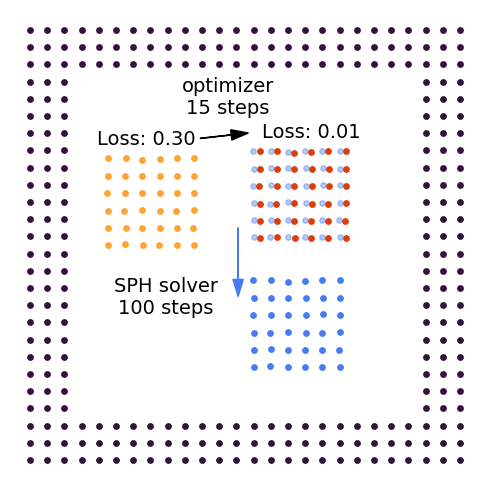

done


In [7]:
def ploting_A(
    optim_final_state, optim_init_state, target_state_final, target_state_init, mask
):
    # Add two plots side by side
    fig = plt.figure(figsize=(5, 5))
    turbo_map = cm.get_cmap("turbo")
    global_size = 15
    plt.scatter(
        target_state_init["r"][mask][:, 0],
        target_state_init["r"][mask][:, 1],
        label="target 0",
        s=global_size,
        c=turbo_map(0.15),
        alpha=0.4,
    )
    plt.scatter(
        target_state_final["r"][mask][:, 0],
        target_state_final["r"][mask][:, 1],
        label="target 100",
        s=global_size,
        c=turbo_map(0.15),
    )
    plt.scatter(
        optim_init_state["r"][mask][:, 0],
        optim_init_state["r"][mask][:, 1],
        label="init",
        s=global_size,
        c=turbo_map(0.7),
    )
    plt.scatter(
        optim_final_state["r"][mask][:, 0],
        optim_final_state["r"][mask][:, 1],
        label="updated",
        s=global_size,
        c=turbo_map(0.85),
    )
    wall = target_state_init["r"][~mask]
    top_lid = wall[:, 1] < 100
    plt.scatter(
        wall[top_lid][:, 0],
        wall[top_lid][:, 1],
        label="wall",
        s=global_size,
        color=turbo_map(0),
    )
    # plt.legend(loc='upper right')
    plt.arrow(0.52, 0.96, 0.09, 0.01, head_width=0.03, head_length=0.05, fc="k", ec="k")
    plt.text(0.6, 1.03, "optimizer\n15 steps", fontsize=14, ha="center", rotation=0)
    plt.text(0.22, 0.94, "Loss: 0.30", fontsize=14)
    plt.text(0.7, 0.96, "Loss: 0.01", fontsize=14)

    plt.arrow(
        0.63,
        0.7,
        0.0,
        -0.15,
        head_width=0.03,
        head_length=0.05,
        fc=turbo_map(0.15),
        ec=turbo_map(0.15),
    )
    plt.text(0.42, 0.45, "SPH solver\n100 steps", fontsize=14, ha="center", rotation=0)

    plt.axis("equal")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    fig.savefig("optim_A.pdf", bbox_inches="tight")
    print("done")


mask = target_state_A["tag"] == 0

ploting_A(final_optim_A, init_optim_A, final_state_A, target_state_A, mask)

In [8]:
init_optim_B = read_h5("datasets/optim_B_init.h5")
final_optim_B = read_h5("datasets/optim_B_final.h5")

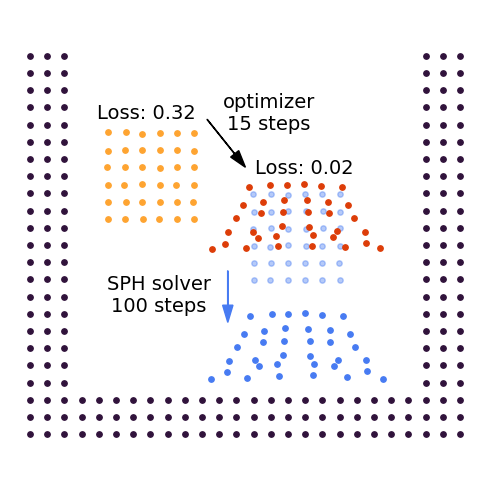

done


In [9]:
def ploting_B(
    optim_final_state, optim_init_state, target_state_final, target_state_init, mask
):
    # Add two plots side by side
    fig = plt.figure(figsize=(5, 5))
    turbo_map = cm.get_cmap("turbo")
    global_size = 15
    plt.scatter(
        target_state_init["r"][mask][:, 0],
        target_state_init["r"][mask][:, 1],
        label="target 0",
        s=global_size,
        c=turbo_map(0.15),
        alpha=0.4,
    )
    plt.scatter(
        target_state_final["r"][mask][:, 0],
        target_state_final["r"][mask][:, 1],
        label="target 100",
        s=global_size,
        c=turbo_map(0.15),
    )
    plt.scatter(
        optim_init_state["r"][mask][:, 0],
        optim_init_state["r"][mask][:, 1],
        label="init",
        s=global_size,
        c=turbo_map(0.7),
    )
    plt.scatter(
        optim_final_state["r"][mask][:, 0],
        optim_final_state["r"][mask][:, 1],
        label="updated",
        s=global_size,
        c=turbo_map(0.85),
    )
    wall = optim_init_state["r"][~mask]
    top_lid = wall[:, 1] < 1.17
    plt.scatter(
        wall[top_lid][:, 0],
        wall[top_lid][:, 1],
        label="wall",
        s=global_size,
        color=turbo_map(0),
    )
    # plt.legend(loc='upper right')
    line = plt.arrow(
        0.54, 0.94, 0.08, -0.1, head_width=0.03, head_length=0.05, fc="k", ec="k"
    )
    plt.text(0.72, 0.91, "optimizer\n15 steps", fontsize=14, ha="center", rotation=0)
    plt.text(0.22, 0.94, "Loss: 0.32", fontsize=14)
    plt.arrow(
        0.6,
        0.5,
        0.0,
        -0.10,
        head_width=0.03,
        head_length=0.05,
        fc=turbo_map(0.15),
        ec=turbo_map(0.15),
    )
    plt.text(0.40, 0.38, "SPH solver\n100 steps", fontsize=14, ha="center", rotation=0)
    plt.text(0.68, 0.78, "Loss: 0.02", fontsize=14)
    plt.axis("equal")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
    fig.savefig("optim_B.pdf", bbox_inches="tight")
    print("done")


mask = target_state_B["tag"] == 0

ploting_B(final_optim_B, init_optim_B, final_state_B, target_state_B, mask)